In [1]:
import keras
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from tqdm.notebook import tqdm

from scipy import stats

from sklearn import datasets

import sys 
sys.path.append("../")
from KDG import KDG

import openml

Using TensorFlow backend.


# Experiment Parameters

In [2]:
max_depth = 4
n_estimators = 4
num_trials = 2

# Data Generation

# Construct & Train Network

## Keurnal Networks

In [3]:
def train_AKN(X, y):
    #X_transform, y_transform = X, y
    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                   max_depth = max_depth)

    rfc.fit(X, y)

    predicted_leaf_ids_across_trees = [np.unique(tree.apply(X), return_inverse = True)[1] for tree_idx, tree in enumerate(rfc.estimators_)]

    return KDG().fit(X, y, predicted_leaf_ids_across_trees)

In [4]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                   max_depth = max_depth)

    rfc.fit(X, y)
    return rfc.predict_proba(X_test)
    

def get_KDE_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    kdg = train_AKN(X, y)
    y_proba_unnormalized = kdg.predict_proba(X_test, pooling = "polytope")

    y_proba = y_proba_unnormalized.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba[:, y_val] /= np.sum(y_proba_unnormalized, axis = 1)
        
    return y_proba

In [ ]:
def clipped_mean(ra, low = 25, high = 75):
    ra = np.array(ra)
    lower_val = np.nanpercentile(ra, low)
    higher_val = np.nanpercentile(ra, high)
    return np.mean(ra[np.where((ra >= lower_val) & (ra <= higher_val))[0]])

In [ ]:
def get_ece(predicted_posterior, y):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 40
    eces_across_y_vals = []
    for y_val in np.unique(y):
        for i in range(num_bins):
            prop = i*1./num_bins
            inds = np.where((predicted_posterior[:, y_val] >= prop) & (predicted_posterior[:, y_val] <= prop+1./num_bins))[0]
            amts.append(len(inds))
            if len(inds) > 0:
                hists.append(len(np.where(y[inds] == y_val)[0])*1./len(inds))
                hists_hat.append(np.mean(predicted_posterior[inds, y_val]))
            else:
                hists.append(prop)
                hists_hat.append(prop + 0.5/num_bins)
        eces_across_y_vals.append(np.dot(np.abs(np.array(hists) - np.array(hists_hat)), amts) / np.sum(amts))
    return np.mean(eces_across_y_vals)

In [ ]:
def get_brier(predicted_posterior, y):
    brier_across_y_vals = []
    for y_val in np.unique(y):
        brier_across_y_vals.append(np.nanmean((predicted_posterior[:, y_val] - (y == y_val).astype('int'))**2))
    return np.mean(brier_across_y_vals)

Dataset Num = 3
N = 3196
D = 36



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  23 | elapsed:    3.5s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  54 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  44 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=

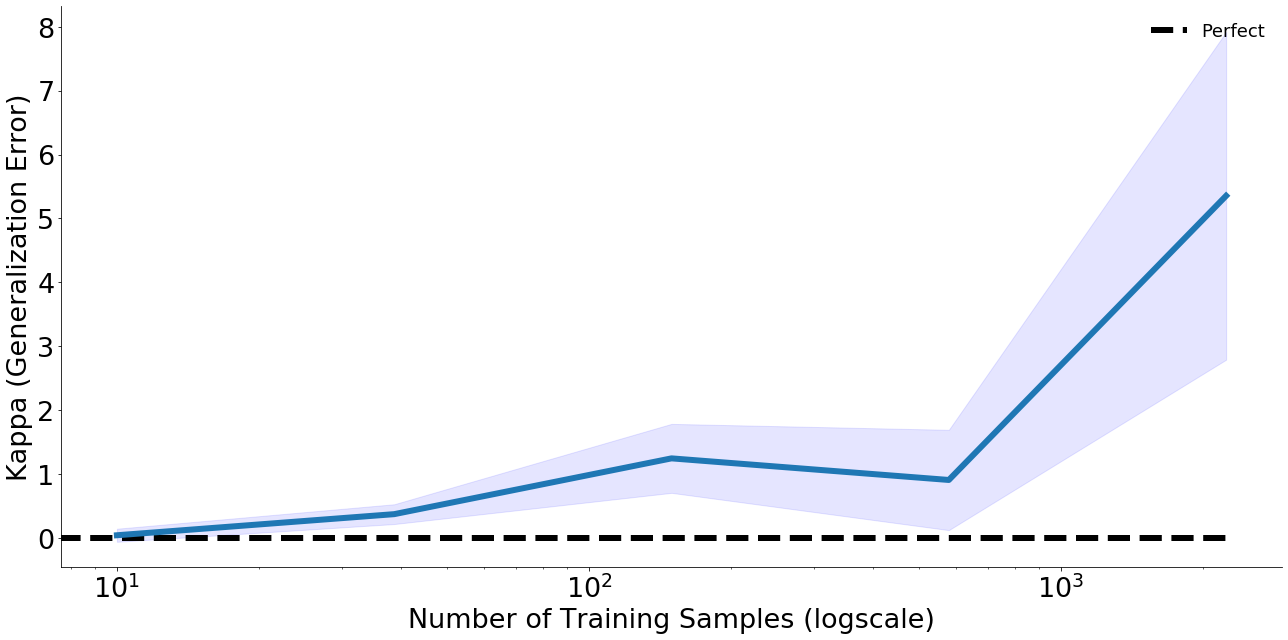

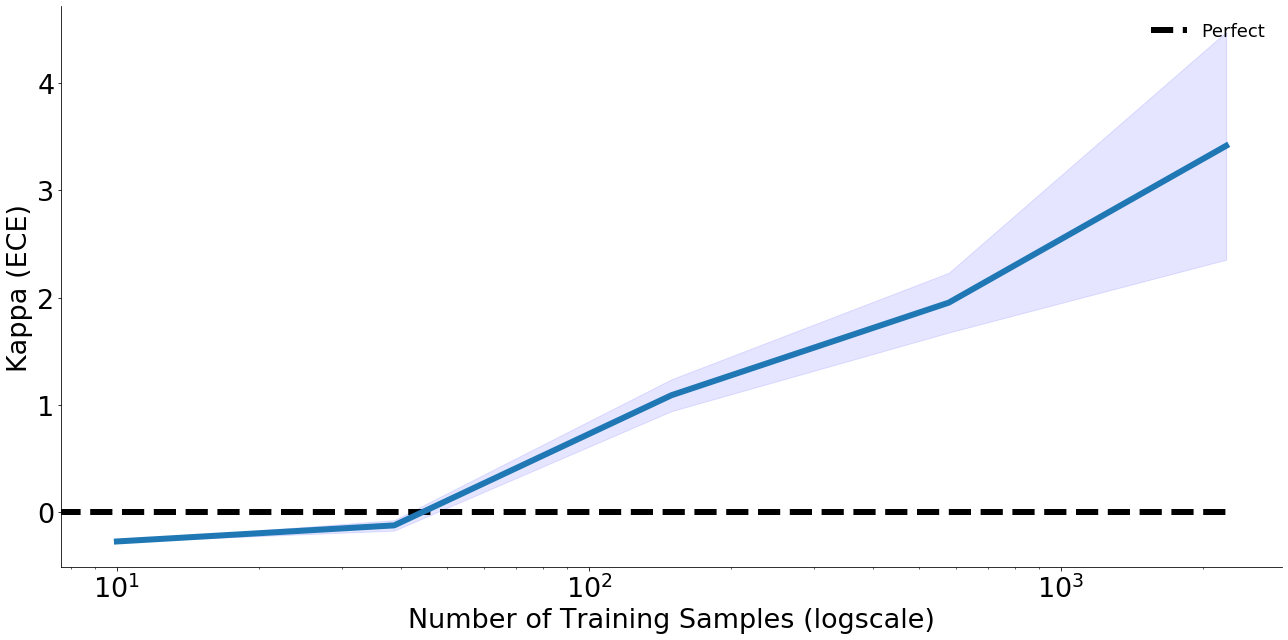

Dataset Num = 6
N = 20000
D = 16



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  37 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:    0.0s remaining:    0.0s
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/

In [ ]:
kappa_acc_means = []
kappa_acc_stds = []

kappa_ece_means = []
kappa_ece_stds = []
ds = []
ns = []
traces_X = []
traces_y = []
for dataset_idx in openml.study.get_suite('OpenML-CC18').tasks:
    successfully_loaded = True
    try:
        X, y = openml.tasks.get_task(dataset_idx).get_X_and_y()
        _, y = np.unique(y, return_inverse = True)
    except:
        print("Skipping Dataset {}".format(dataset_idx))
        successfully_loaded = False
    
    if successfully_loaded:
        print("Dataset Num = {}".format(dataset_idx))
        print("N = {}".format(len(X)))
        print("D = {}".format(np.shape(X)[1]))
        print()
        
        
        if len(X) > 10 / .7 and np.shape(X)[1] < 50:
            n_ra = np.logspace(np.log10(10), np.log10(len(X) * 0.7), num = 5, base = 10)
            for n in tqdm(n_ra):
                kappa_acc_across_trials = []
                kappa_ece_across_trials = []
                for trial_idx in range(num_trials):
                    try:
                        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
                        unique_y_train = np.unique(y_train)
                        counts = np.bincount(y_test)
                        max_class_frequency = np.max(counts)
                        bayes_error = max_class_frequency / len(y_test)
                        bayes_ece = get_brier(np.array([(counts / np.sum(counts)) for _ in range(len(y_test))]), y_test)

                        KDE_y_proba = get_KDE_y_proba(X_train, y_train, n, X_test)
                        network_y_proba = get_network_y_proba(X, y, n, X_test)

                        KDE_acc = (bayes_error + 1e-12) / (np.nanmean(np.argmax(KDE_y_proba, axis = 1) != y_test) + 1e-12)
                        network_acc = (bayes_error + 1e-12) / (np.nanmean(np.argmax(network_y_proba, axis = 1) != y_test) + 1e-12)
                        kappa_acc_across_trials.append(KDE_acc - network_acc)

                        KDE_ece = bayes_ece / get_brier(KDE_y_proba, y_test)
                        network_ece = bayes_ece / get_brier(network_y_proba, y_test)
                        kappa_ece_across_trials.append(KDE_ece - network_ece)
                    except:
                        pass

                if len(kappa_acc_across_trials) > 0:
                    kappa_acc_means.append(np.mean(kappa_acc_across_trials))
                    kappa_acc_stds.append(np.std(kappa_acc_across_trials))
                    kappa_ece_means.append(np.mean(kappa_ece_across_trials))
                    kappa_ece_stds.append(np.std(kappa_ece_across_trials))
                    ds.append(np.shape(X)[1])
                    ns.append(n)
                    traces_X.append(np.sum(np.matmul(np.transpose(X), X)))
                    traces_y.append(np.sum(np.matmul(np.transpose(X), y)))
            
            if len(kappa_acc_means) > 1:
                figs, ax = plt.subplots(1, 1, figsize = (18, 9))
                figs.set_facecolor("white")

                ax.tick_params(axis='both', which='major', labelsize=27)
                ax.plot(n_ra, kappa_acc_means[-len(n_ra):])
                ax.hlines(0.0, 0, np.max(n_ra[:len(kappa_acc_means)]), linestyle = "dashed", label = "Perfect", color = "black")
                ax.legend(fontsize = 18, loc = "upper right", frameon = False)
                ax.set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
                ax.set_ylabel("Kappa (Generalization Error)", fontsize = 27)
                ax.set_xscale("log")
                ax.fill_between(n_ra, 
                               np.array(kappa_acc_means)[-len(n_ra):] + np.array(kappa_acc_stds)[-len(n_ra):],
                               np.array(kappa_acc_means)[-len(n_ra):] - np.array(kappa_acc_stds)[-len(n_ra):],
                               alpha = .1,
                               color = "blue")
                for side in {"right", "top"}:
                        ax.spines[side].set_visible(False)


                figs.tight_layout()

                plt.show()
                
            if len(kappa_ece_means) > 1:
                figs, ax = plt.subplots(1, 1, figsize = (18, 9))
                figs.set_facecolor("white")

                ax.tick_params(axis='both', which='major', labelsize=27)
                ax.plot(n_ra, kappa_ece_means[-len(n_ra):])
                ax.hlines(0.0, 0, np.max(n_ra), linestyle = "dashed", label = "Perfect", color = "black")
                ax.legend(fontsize = 18, loc = "upper right", frameon = False)
                ax.set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
                ax.set_ylabel("Kappa (ECE)", fontsize = 27)
                ax.set_xscale("log")
                ax.fill_between(n_ra, 
                               np.array(kappa_ece_means)[-len(n_ra):] + np.array(kappa_ece_stds)[-len(n_ra):],
                               np.array(kappa_ece_means)[-len(n_ra):] - np.array(kappa_ece_stds)[-len(n_ra):],
                               alpha = .1,
                               color = "blue")
                for side in {"right", "top"}:
                        ax.spines[side].set_visible(False)


                figs.tight_layout()

                plt.show()
        else:
            print("Skipping Dataset")
            print()

    


In [ ]:
figs, ax = plt.subplots(1, 1, figsize = (12, 6))
kappa_acc_means = np.array(kappa_acc_means)
ax.boxplot(kappa_acc_means, widths = 1)
ax.hlines(0.0, 0, 2, linewidth = 1, color = "green")
ax.set_ylim((-5, 5))
ax.set_xticks([])
ax.set_ylabel("Kappa", fontsize = 16)

figs.suptitle("Kappa Difference (KDE - RF) for Generalization Error", fontsize = 16)

In [ ]:
figs, ax = plt.subplots(1, 1, figsize = (12, 6))
finite_idxs = np.where(~np.isnan(kappa_ece_means))
kappa_ece_means = np.array(kappa_ece_means)
ax.boxplot(kappa_ece_means[finite_idxs], widths = 1)
ax.hlines(0.0, 0, 2, linewidth = 1, color = "green")
ax.set_xticks([])
ax.set_ylabel("ECE", fontsize = 16)

figs.suptitle("Kappa Difference (KDE - RF)", fontsize = 16)

In [ ]:
plt.scatter(np.array(ns)[finite_idxs], kappa_ece_means[finite_idxs])

In [ ]:
plt.scatter(np.array(ds)[finite_idxs], kappa_ece_means[finite_idxs])

In [ ]:
plt.scatter(np.array(ns)[finite_idxs] / np.array(ds)[finite_idxs], kappa_ece_means[finite_idxs])

In [ ]:
plt.scatter(np.array(traces_X)[np.where((np.abs(traces_X) < 1e8) & (~np.isnan(kappa_ece_means)))], kappa_ece_means[np.where((np.abs(traces_X) < 1e8) & (~np.isnan(kappa_ece_means)))])

In [ ]:
plt.scatter(np.array(traces_y)[np.where((np.abs(traces_y) < 1e8) & (~np.isnan(kappa_ece_means)))[0]], kappa_ece_means[np.where((np.abs(traces_y) < 1e8) & (~np.isnan(kappa_ece_means)))[0]])